<a href="https://colab.research.google.com/github/pnperl/Equity/blob/main/StockBaba_PNP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Enter the stock symbol (e.g., HDFCBANK.NS for HDFC Bank): ^NSEI


[*********************100%***********************]  1 of 1 completed


Loading saved model: ^NSEI_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━

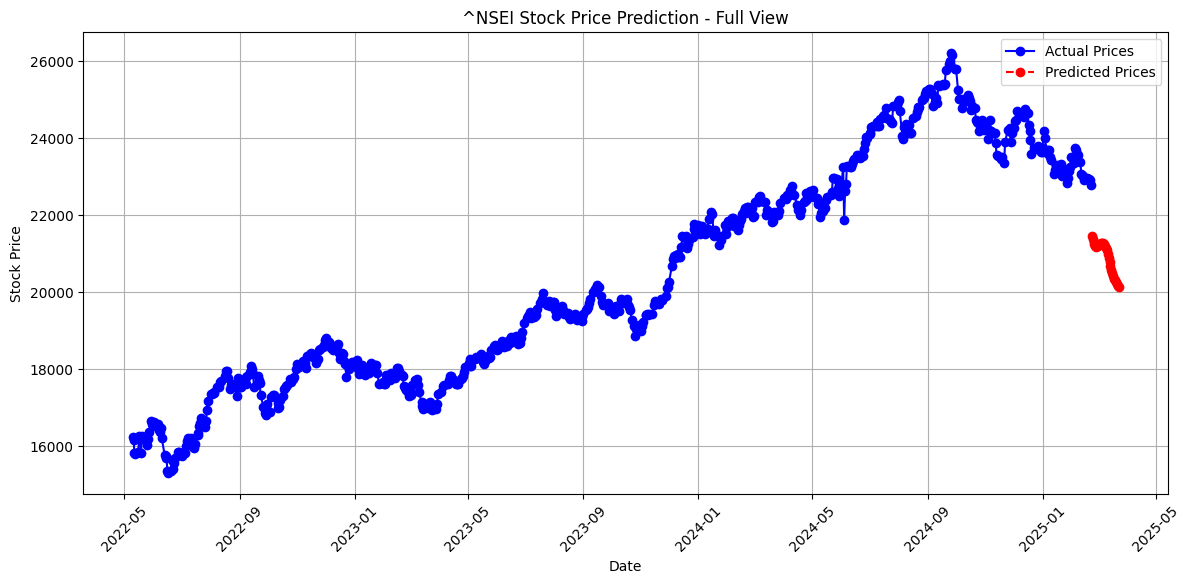

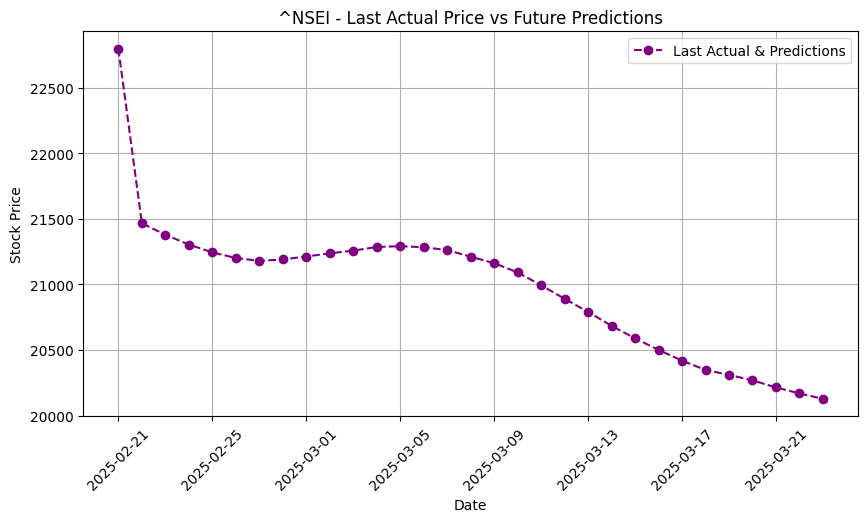


Technical Indicators Summary for ^NSEI:
-----------------------------------------
- 50-day Moving Average (50_MA): 23464.76
- 200-day Moving Average (200_MA): 24058.64
- Volatility (50-day Std Dev): 460.27
- RSI (Relative Strength Index): 29.55 (Oversold)
- MACD: -162.57 (Bearish)
- On-Balance Volume (OBV): 70109000.00


Sentiment Analysis Summary for ^NSEI:
-----------------------------------------
- Sentiment Score: 0.37 (Positive)
- Interpretation: Positive sentiment indicates favorable news.

Top 5 News Articles:

1. Date: 2025-02-22
   Title: Nifty Next 50, Nifty Midcap 150, Nifty Smallcap 250: When largecaps correct like smallcaps
   Description: Investors advised to seek refuge in large-caps amid small-cap rout, but Nifty Next 50 index proves otherwise.
   URL: https://www.thehindubusinessline.com/portfolio/nifty-next-50-nifty-midcap-150-nifty-smallcap-250-when-largecaps-correct-like-smallcaps/article69252198.ece
   Sentiment Score: 0.86

2. Date: 2025-02-22
   Title: F&O Track

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings
import tensorflow as tf
tf.get_logger().setLevel('ERROR')  # Suppress Keras warnings

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import requests
import json
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download nltk VADER sentiment analysis package
nltk.download('vader_lexicon')

# === Step 1: Ask User for Stock Input ===
stock_symbol = input("Enter the stock symbol (e.g., HDFCBANK.NS for HDFC Bank): ").strip()

# === Step 2: Fetch Historical Stock Data ===
df = yf.download(stock_symbol, start="2010-01-01", period="1d")

# === Step 3: Add Market Indicators ===
df["50_MA"] = df["Close"].rolling(window=50).mean()
df["200_MA"] = df["Close"].rolling(window=200).mean()
df["Volatility"] = df["Close"].rolling(window=50).std()

# MACD Calculation
df["MACD"] = df["Close"].ewm(span=12, adjust=False).mean() - df["Close"].ewm(span=26, adjust=False).mean()

# RSI Calculation
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()  # Calculate daily price changes
    gains = delta.where(delta > 0, 0)  # Separate gains
    losses = -delta.where(delta < 0, 0)  # Separate losses

    # Calculate average gains and losses
    avg_gain = gains.rolling(window=window).mean()
    avg_loss = losses.rolling(window=window).mean()

    # Calculate Relative Strength (RS)
    rs = avg_gain / avg_loss

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = calculate_rsi(df)

# On-Balance Volume (OBV)
def calculate_obv(data):
    obv = np.where(data['Close'] > data['Close'].shift(1), data['Volume'],
                  np.where(data['Close'] < data['Close'].shift(1), -data['Volume'], 0)).cumsum()
    return obv

df['OBV'] = calculate_obv(df)

# Drop NaN values from indicators
df.dropna(inplace=True)

# === Step 4: Sentiment Analysis (Updated with Company Name) ===
def get_sentiment_score_and_news(stock):
    try:
        # Fetch company name using yfinance
        ticker = yf.Ticker(stock)
        company_name = ticker.info.get('longName', stock.split('.')[0])  # Use longName or fallback to stock symbol

        # Search for news using the company name
        url = f"https://newsapi.org/v2/everything?q={company_name}&apiKey=afce3fd1c27d40d186f4f3a3b1639a5f&sortBy=publishedAt&pageSize=5"
        response = requests.get(url)
        news_data = json.loads(response.text)

        # Check if the API request was successful
        if response.status_code != 200 or news_data.get("status") != "ok":
            print(f"NewsAPI Error: {news_data.get('message', 'Unknown error')}")
            return 0, []  # Return neutral sentiment and no news

        analyzer = SentimentIntensityAnalyzer()
        sentiment_scores = []
        top_news = []

        for article in news_data.get("articles", []):
            title = article["title"]
            description = article.get("description", "No description available")
            url = article.get("url", "#")
            published_at = article.get("publishedAt", "")[:10]  # Extract date (YYYY-MM-DD)
            score = analyzer.polarity_scores(title)["compound"]
            sentiment_scores.append(score)
            top_news.append({"title": title, "description": description, "url": url, "score": score, "date": published_at})

        if sentiment_scores:
            return np.mean(sentiment_scores), top_news
        else:
            print("No news articles found.")
            return 0, []  # Neutral sentiment if no news found
    except Exception as e:
        print(f"Error fetching news: {e}")
        return 0, []  # Default to neutral sentiment if API fails

# Fetch sentiment score and top news
sentiment_score, top_news = get_sentiment_score_and_news(stock_symbol)
df["Sentiment"] = sentiment_score

# === Step 5: Train or Load Model ===
# Features: Close, 50_MA, 200_MA, Volatility, RSI, MACD, OBV, Sentiment
features = ["Close", "50_MA", "200_MA", "Volatility", "RSI", "MACD", "OBV", "Sentiment"]
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df[features])

# Create sequences for LSTM
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps][0])  # Predicting Close Price
    return np.array(X), np.array(y)

time_steps = 60
X, y = create_sequences(df_scaled, time_steps)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Check if model exists
model_path = f"{stock_symbol}_model.h5"
if os.path.exists(model_path.replace('.h5', '.keras')):  # Check for .keras file
    print(f"Loading saved model: {model_path.replace('.h5', '.keras')}")
    model = load_model(model_path.replace('.h5', '.keras'))  # Load .keras file
else:
    print("Training new model...")

    # Build LSTM Model
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),  # Explicitly define input shape
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])

    model.compile(optimizer="adam", loss="mean_squared_error")
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

    # Save the trained model in native Keras format
    model.save(model_path.replace('.h5', '.keras'))  # Save as .keras file
    print(f"Model saved as {model_path.replace('.h5', '.keras')}")

# Predict future stock prices
future_steps = 30  # Predict next 30 days
future_prices = []

last_sequence = X_test[-1]

for _ in range(future_steps):
    next_pred = model.predict(np.expand_dims(last_sequence, axis=0))[0][0]
    future_prices.append(next_pred)
    last_sequence = np.roll(last_sequence, -1, axis=0)
    last_sequence[-1, 0] = next_pred  # Update last price

# Convert back to original scale
future_prices = scaler.inverse_transform([[p] + [0] * (len(features) - 1) for p in future_prices])[:, 0]

# Prepare data for plotting
actual_dates = df.index[-len(y_test):]  # Dates corresponding to test data
predicted_dates = [actual_dates[-1] + datetime.timedelta(days=i+1) for i in range(future_steps)]

# Convert last known actual prices back to original scale
actual_prices = scaler.inverse_transform([[p] + [0] * (len(features) - 1) for p in y_test])[:, 0]
last_actual_price = actual_prices[-1]  # Last known actual price

# === Step 6: Plot Full Historical Prices + Future Predictions ===
plt.figure(figsize=(14, 6))
plt.plot(actual_dates, actual_prices, label="Actual Prices", color='blue', marker="o")
plt.plot(predicted_dates, future_prices, label="Predicted Prices", color='red', linestyle="dashed", marker="o")

# Formatting
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title(f"{stock_symbol} Stock Price Prediction - Full View")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# === Step 7: Plot Last Actual Price vs. Future Predictions ===
plt.figure(figsize=(10, 5))
plt.plot([actual_dates[-1]] + predicted_dates, [last_actual_price] + list(future_prices),
         label="Last Actual & Predictions", color='purple', marker="o", linestyle="dashed")

# Formatting
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title(f"{stock_symbol} - Last Actual Price vs Future Predictions")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# === Step 8: Summaries ===
# Technical Indicators Summary
technical_summary = f"""
Technical Indicators Summary for {stock_symbol}:
-----------------------------------------
- 50-day Moving Average (50_MA): {df['50_MA'].iloc[-1]:.2f}
- 200-day Moving Average (200_MA): {df['200_MA'].iloc[-1]:.2f}
- Volatility (50-day Std Dev): {df['Volatility'].iloc[-1]:.2f}
- RSI (Relative Strength Index): {df['RSI'].iloc[-1]:.2f} ({'Overbought' if df['RSI'].iloc[-1] > 70 else 'Oversold' if df['RSI'].iloc[-1] < 30 else 'Neutral'})
- MACD: {df['MACD'].iloc[-1]:.2f} ({'Bullish' if df['MACD'].iloc[-1] > 0 else 'Bearish'})
- On-Balance Volume (OBV): {df['OBV'].iloc[-1]:.2f}
"""

# Sentiment Analysis Summary
sentiment_summary = f"""
Sentiment Analysis Summary for {stock_symbol}:
-----------------------------------------
- Sentiment Score: {sentiment_score:.2f} ({'Positive' if sentiment_score > 0 else 'Negative' if sentiment_score < 0 else 'Neutral'})
- Interpretation: {'Positive sentiment indicates favorable news.' if sentiment_score > 0 else 'Negative sentiment indicates unfavorable news.' if sentiment_score < 0 else 'Neutral sentiment indicates mixed or no significant news.'}

Top 5 News Articles:
"""

# Add top 5 news articles to the summary
for i, news in enumerate(top_news, 1):
    sentiment_summary += f"""
{i}. Date: {news['date']}
   Title: {news['title']}
   Description: {news['description']}
   URL: {news['url']}
   Sentiment Score: {news['score']:.2f}
"""

# Stock Analysis Summary
overall_summary = f"""
Stock Analysis Summary for {stock_symbol}:
-----------------------------------------
- Last recorded stock price: {last_actual_price:.2f}
- Model trained with 8 factors over {len(df)} days.
- Predicted next 30 days price trend: {'Upward' if future_prices[-1] > last_actual_price else 'Downward'}

8 Factors Used in the Model:
1. Close Price: The most recent closing price of the stock.
2. 50-day Moving Average (50_MA): The average closing price over the last 50 days.
3. 200-day Moving Average (200_MA): The average closing price over the last 200 days.
4. Volatility: The standard deviation of the last 50 days' closing prices.
5. RSI (Relative Strength Index): A momentum indicator measuring overbought/oversold conditions.
6. MACD (Moving Average Convergence Divergence): A trend-following momentum indicator.
7. On-Balance Volume (OBV): A momentum indicator using volume flow.
8. Sentiment Score: The average sentiment score from news articles.
"""

# Print Summaries
print(technical_summary)
print(sentiment_summary)
print(overall_summary)